In [60]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import math
import hamiltorch
import torch.distributions as dist
import seaborn as sns

In [61]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

In [62]:
# find total number of parameters in model
num_params = 0
for param in model.parameters():
    num_params += param.numel()
print(f"Total number of parameters in model: {num_params}")

Total number of parameters in model: 33


In [63]:
X, y = make_circles(n_samples=100, noise=0.02, random_state=42)

In [64]:
X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))

In [65]:
def negative_log_likelihood(parameters):
    params_list = hamiltorch.util.unflatten(model, parameters)
    w1, b1, w2, b2 = params_list
    res=0
    for i in range(len(X)):
        logit = F.linear(X[i], w1, b1)
        logit = F.relu(logit)
        logit = F.linear(logit, w2, b2)
        res+=torch.distributions.Bernoulli(logits=logit).log_prob(y[i])
    return -res

def negative_log_prior (parameters):
    normal_dist = dist.Normal(0, 1)
    return -normal_dist.log_prob(parameters).sum()

def negative_log_joint(parameters):
    return negative_log_likelihood(parameters) + negative_log_prior(parameters)

In [66]:
def log_prob(parameters):
    return -1*negative_log_joint(parameters)

In [67]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for i in range(2000):
    optimizer.zero_grad()
    loss = negative_log_joint(hamiltorch.util.flatten(model))
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Epoch {i}, loss {loss.item()}')

Epoch 0, loss 102.14932250976562
Epoch 100, loss 99.56342315673828
Epoch 200, loss 99.13848876953125
Epoch 300, loss 98.71701049804688
Epoch 400, loss 98.2728271484375
Epoch 500, loss 97.99209594726562
Epoch 600, loss 97.87059020996094
Epoch 700, loss 97.82487487792969
Epoch 800, loss 97.80830383300781
Epoch 900, loss 97.8035888671875
Epoch 1000, loss 97.80123901367188
Epoch 1100, loss 97.799072265625
Epoch 1200, loss 97.79826354980469
Epoch 1300, loss 97.79859924316406
Epoch 1400, loss 97.79750061035156
Epoch 1500, loss 97.79719543457031
Epoch 1600, loss 97.7981185913086
Epoch 1700, loss 97.79661560058594
Epoch 1800, loss 97.79661560058594
Epoch 1900, loss 97.79662322998047


In [69]:
type(X[0])

torch.Tensor

/var/folders/pj/3q7s4h6102n3v3kt6t8p1kzr0000gn/T/ipykernel_3157/2030590214.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


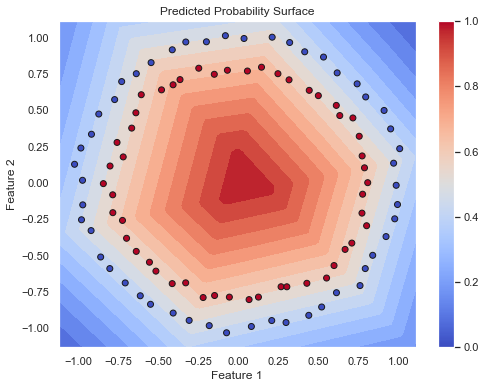

In [70]:
from matplotlib import pyplot as plt
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

x_range = torch.linspace(x_min, x_max, 100)
y_range = torch.linspace(y_min, y_max, 100)
xx, yy = torch.meshgrid(x_range, y_range)
grid_points = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

# Calculate predicted probability surface using MAP estimate
with torch.no_grad():
    logits = model(grid_points)
    predicted_prob = torch.sigmoid(logits).reshape(xx.shape).numpy()

# Plot the predicted probability surface
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, predicted_prob, levels=20, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', linewidths=1)
plt.title('Predicted Probability Surface')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [71]:
type(X[0])

torch.Tensor

In [72]:
negative_log_joint(hamiltorch.util.flatten(model))

tensor([97.7965], grad_fn=<AddBackward0>)

In [73]:
from torch.autograd.functional import hessian

In [74]:
input = hamiltorch.util.flatten(model)
output = hessian(negative_log_joint, input)
output

tensor([[11.3620,  0.7389,  0.0000,  ..., -2.2432,  0.0000, -7.9728],
        [ 0.7389, 10.9826,  0.0000,  ...,  1.1337,  0.0000, -6.4671],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-2.2432,  1.1337,  0.0000,  ...,  8.9431,  0.0000,  8.5888],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [-7.9728, -6.4671,  0.0000,  ...,  8.5888,  0.0000, 25.6179]])

In [75]:
# invert the output matrix
covariance = torch.inverse(output)
covariance

tensor([[ 0.4872,  0.0656,  0.0000,  ..., -0.3255,  0.0000,  0.2156],
        [ 0.0656,  0.3791,  0.0000,  ...,  0.0933,  0.0000,  0.1822],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.3255,  0.0933,  0.0000,  ...,  1.0862,  0.0000, -0.3087],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.2156,  0.1822,  0.0000,  ..., -0.3087,  0.0000,  0.6914]])

In [76]:
covariance.shape

torch.Size([33, 33])

In [77]:
np.linalg.eigvals(covariance)

array([1.17316132e+02, 4.53964090e+00, 1.54290962e+00, 1.20960809e-02,
       2.52073277e-02, 2.81117167e-02, 1.04304396e-01, 9.36969668e-02,
       9.20761049e-01, 9.93247271e-01, 1.00080824e+00, 9.99575853e-01,
       7.78064191e-01, 3.16949576e-01, 6.74464166e-01, 4.14830953e-01,
       4.94969517e-01, 5.01717567e-01, 5.05288422e-01, 5.09205937e-01,
       5.61847568e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00], dtype=float32)

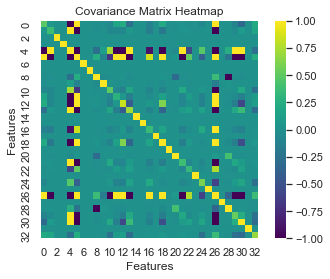

In [78]:
# Create a heatmap using Seaborn with a different colormap (e.g., "viridis")
sns.set()
plt.figure(figsize=(6, 4))
sns.heatmap(covariance, annot=False, cmap="viridis", fmt=".2f", square=True, vmin=-1, vmax=1)  # Adjust vmin and vmax as needed

# Customize the plot (optional)
plt.title("Covariance Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")

# Display the heatmap
plt.show()

In [79]:
off_diag_ignore = torch.zeros_like(output)
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        if i == j:
            off_diag_ignore[i, j] = output[i, j]
        else:
            off_diag_ignore[i, j] = 0
off_diag_ignore

tensor([[11.3620,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.9826,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  8.9431,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 25.6179]])

In [80]:
off_diag_ignore_covariance = torch.inverse(off_diag_ignore)
off_diag_ignore_covariance

tensor([[0.0880, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0911, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1118, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0390]])

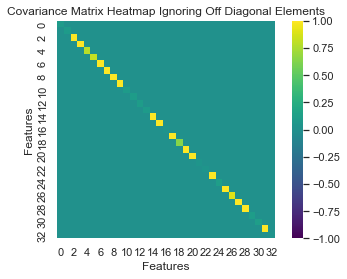

In [81]:
# Create a heatmap using Seaborn with a different colormap (e.g., "viridis")
sns.set()
plt.figure(figsize=(6, 4))
sns.heatmap(off_diag_ignore_covariance, annot=False, cmap="viridis", fmt=".2f", square=True, vmin=-1, vmax=1)  # Adjust vmin and vmax as needed

# Customize the plot (optional)
plt.title("Covariance Matrix Heatmap Ignoring Off Diagonal Elements")
plt.xlabel("Features")
plt.ylabel("Features")

# Display the heatmap
plt.show()

In [175]:
parameters = hamiltorch.util.flatten(model)

In [195]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.randn_like(parameters)
params_hmc = hamiltorch.sample(log_prob_func=log_prob, params_init=parameters, num_samples=1000,
                               step_size=0.1, num_steps_per_sample=10)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:04:16 | 0d:00:00:00 | #################### | 1000/1000 | 3.90       
Acceptance Rate 0.55


In [196]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
samples = coords_hmc[100:]
samples.shape

(900, 33)

In [197]:
def prediction(x):
    array = []
    for parameter in samples:
        params_list = hamiltorch.util.unflatten(model, torch.tensor(parameter))
        w1, b1, w2, b2 = params_list
        logit = F.linear(x, w1, b1)
        logit = F.relu(logit)
        logit = F.linear(logit, w2, b2)
        array.append(torch.sigmoid(logit).item())
    return np.mean(array), np.std(array)

In [198]:
prediction(torch.tensor([10.0,1.0]))

(0.010403971879457949, 0.07934606991173325)

/var/folders/pj/3q7s4h6102n3v3kt6t8p1kzr0000gn/T/ipykernel_3157/2578230896.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cmap_mean, ax=ax1)
/var/folders/pj/3q7s4h6102n3v3kt6t8p1kzr0000gn/T/ipykernel_3157/2578230896.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cmap_std, ax=ax2)


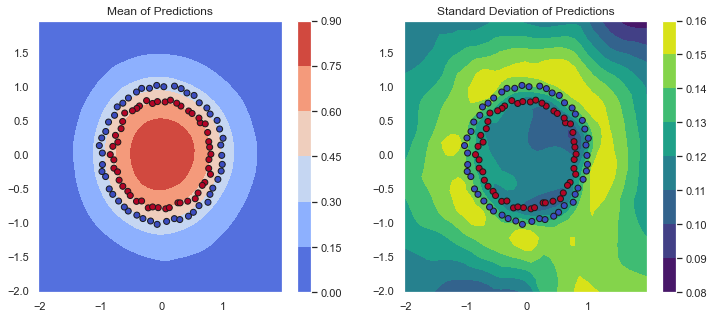

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of x and y values for the grid
x_min, x_max = min(X[:, 0]) - 1, max(X[:, 0]) + 1
y_min, y_max = min(X[:, 1]) - 1, max(X[:, 1]) + 1

# Generate a grid of points
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Initialize arrays to store mean and std values
mean_values = np.zeros_like(xx)
std_values = np.zeros_like(xx)

# Calculate mean and std for each point on the grid
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        x_point = np.array([xx[i, j], yy[i, j]])
        mean, std = prediction(torch.from_numpy(x_point).float())
        mean_values[i, j] = mean
        std_values[i, j] = std

# Create a figure with subplots for mean and std
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the mean colormap
cmap_mean = ax1.contourf(xx, yy, mean_values, cmap='coolwarm')
ax1.set_title('Mean of Predictions')
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', linewidths=1)

# Plot the std colormap
cmap_std = ax2.contourf(xx, yy, std_values, cmap='viridis')
ax2.set_title('Standard Deviation of Predictions')
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', linewidths=1)

# Add colorbars
fig.colorbar(cmap_mean, ax=ax1)
fig.colorbar(cmap_std, ax=ax2)

# Show the plot
plt.show()

In [ ]:
# observation near the data the std is low. The std is high in the region where there is no data.